# Modeling Notebook Overview

This notebook trains and evaluates predictive models using the engineered dataset. It includes:
- Data loading and preprocessing
- Feature selection
- Model training and tuning
- Evaluation and comparison
- Final predictions and export

## Data loading and preprocessing

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import polars as pl

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
)

import xgboost as xgb
import lightgbm as lgb

from src.utils.plot_utils import (
    plot_roc_curve,
    plot_confusion_matrix,
)

from src.utils.modeling_utils import (
    get_feature_importance,
    evaluate_model,
    prediction_metrics,
    print_error_rate
)

from src.utils.custom_transformers import ColumnSanitizer, InfReplacer, ColumnSelector
import matplotlib.pyplot as plt


In [4]:
from sklearn.pipeline import Pipeline
import re

def get_pipeline(model_obj, feature_selector=None):
    """
    Constructs a pipeline with custom preprocessing, optional feature selection, and a model.

    Parameters:
    - model_obj: sklearn estimator (classifier or regressor)
    - feature_selector: sklearn transformer (e.g. SelectFromModel), or None

    Returns:
    - pipeline: sklearn Pipeline object
    """
    steps = [
        ("sanitize_columns", ColumnSanitizer()),
        ("replace_inf", InfReplacer())
    ]

   # If it's a list, wrap it in ColumnSelector
    if feature_selector is not None:
        if isinstance(feature_selector, list):
            feature_selector = ColumnSelector(feature_selector)
        steps.append(("feature_selector", feature_selector))
        
    steps.append(("model", model_obj))

    return Pipeline(steps=steps)


def sanitize_columns(df):
    """ Replace special characters with underscore"""
    df.columns = [
        re.sub(r'[^a-zA-Z0-9_]', '_', col) 
        for col in df.columns
    ]
    return df

In [5]:
risk_df = pl.read_parquet("../data/processed/data_aggregated_train.parquet")
risk_df = risk_df.to_pandas()
test_df = pl.read_parquet("../data/processed/data_aggregated_test_v1.parquet")
test_df = test_df.to_pandas()
print(risk_df.shape)
print(test_df.shape)

(307500, 580)
(48744, 579)


In [6]:
risk_df = sanitize_columns(risk_df)
risk_df.shape

(307500, 580)

## Train / Validation / Test Split

We split the dataset into three parts:
- **Training set (70%)**: Used to train the model
- **Validation set (15%)**: Used for tuning and early stopping
- **Test set (15%)**: Used for final evaluation

In [7]:

X = risk_df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = risk_df['TARGET']

x_train, x_vt, y_train, y_vt = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
x_validation, x_test, y_validation, y_test = train_test_split(x_vt, y_vt, test_size=0.5, random_state=0, stratify=y_vt)

print(f"x_train :{x_train.shape}, Y train : {y_train.shape}")
print(f"x_test :{x_test.shape}, Y test : {y_test.shape}")
print(f"x_validation :{x_validation.shape}, y_validation : {y_validation.shape}")

x_train :(215250, 578), Y train : (215250,)
x_test :(46125, 578), Y test : (46125,)
x_validation :(46125, 578), y_validation : (46125,)


## Feature Selection

Feature selection helps reduce dimensionality, improve model performance, and enhance interpretability. By identifying and retaining only the most informative features, we minimize noise and avoid overfitting.

In [8]:
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt', 
    max_depth=7, 
    learning_rate=0.01, 
    n_estimators= 2000, 
    class_weight='balanced', 
    subsample=0.9, 
    colsample_bytree= 0.8, 
    ramdom_state=42, 
    n_jobs=-1)

metrics_df = evaluate_model(lgb_model, "LightGBM", x_train, y_train, x_validation, y_validation)

[LightGBM] [Warning] Unknown parameter: ramdom_state
[LightGBM] [Warning] Unknown parameter: ramdom_state
[LightGBM] [Info] Number of positive: 17376, number of negative: 197874
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.362225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60894
[LightGBM] [Info] Number of data points in the train set: 215250, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: ramdom_state
[LightGBM] [Warning] Unknown parameter: ramdom_state

📊 Classification Report for LightGBM:

              precision  

In [9]:
metrics_df

,Model,ROC AUC,F1 Macro,F1 Weighted,Precision,Recall
0,LightGBM,0.785229,0.574522,0.803236,0.19467,0.670784


In [10]:
feature_imp = pd.DataFrame(sorted(zip(lgb_model.feature_importances_, x_train.columns)),columns=['Value','Feature'])

features_df = feature_imp.sort_values(by="Value", ascending=False)
fi_lgb = list(features_df[features_df['Value']>0]['Feature'])
len(fi_lgb)

450

Identified 450 out of 580 features with non-zero importance. 

In [11]:

import  pickle
with open('../data/models/lgb_select_features_v2.txt','wb') as fp:
    pickle.dump(fi_lgb, fp)
print('The no. of features selected:',len(fi_lgb))

The no. of features selected: 450


## Model Training

Next, I’ll experiment with XGBoost and LightGBM models to refine the selection further.

 - LightGBM’s speed, interpretability, and ability to handle missing values and complex patterns make it a reliable and efficient tool for feature selection in real-world datasets

 - XGBoost’s scalability, regularization capabilities, and strong performance on structured data make it a powerful and reliable tool for feature selection in real-world datasets.

## Evulate LightGBM model 

In [12]:
lgb_pipeline = get_pipeline(
    lgb_model,
    feature_selector=fi_lgb
    )

In [13]:
result = evaluate_model(
    model=lgb_pipeline,
    model_name="LightGBM",
    X_train=x_train,
    y_train=y_train,
    X_test=x_validation,
    y_test=y_validation
)   

[LightGBM] [Warning] Unknown parameter: ramdom_state
[LightGBM] [Warning] Unknown parameter: ramdom_state
[LightGBM] [Info] Number of positive: 17376, number of negative: 197874
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.304716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58005
[LightGBM] [Info] Number of data points in the train set: 215250, number of used features: 450
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: ramdom_state
[LightGBM] [Warning] Unknown parameter: ramdom_state

📊 Classification Report for LightGBM:

              precision    recall  f1-score   support

           0      0.963     0.757     0.848     42401
           1      0.195     0.669     0.302      3724

    accurac

In [14]:
result

,Model,ROC AUC,F1 Macro,F1 Weighted,Precision,Recall
0,LightGBM,0.784841,0.574642,0.803586,0.194701,0.668904


Next try XGBoost model

In [15]:
params_xgboost ={
    "eval_metric": "logloss",
    "scale_pos_weight": 11.4,        
    "learning_rate": 0.05,               
    "max_depth": 3,                      
    "min_child_weight": 5,            
    "subsample": 0.8,                    
    "colsample_bytree": 0.8,
    "n_estimators": 200,                             
    "random_state": 42                     
}



In [16]:
xgb_model = xgb.XGBClassifier(**params_xgboost)
Pipeline_xgb = get_pipeline(xgb_model)

In [17]:
metrics_df_xgb = evaluate_model(
    model=Pipeline_xgb,
    model_name="XGBoost",
    X_train=x_train,
    y_train=y_train,
    X_test=x_validation,
    y_test=y_validation
)


📊 Classification Report for XGBoost:

              precision    recall  f1-score   support

           0      0.964     0.710     0.818     42401
           1      0.174     0.694     0.278      3724

    accuracy                          0.709     46125
   macro avg      0.569     0.702     0.548     46125
weighted avg      0.900     0.709     0.774     46125



In [18]:
metrics_df_xgb

,Model,ROC AUC,F1 Macro,F1 Weighted,Precision,Recall
0,XGBoost,0.773816,0.547876,0.774188,0.173808,0.693878


In [19]:
feature_importances_xgb = get_feature_importance(Pipeline_xgb)
feature_importances_xgb
fi_xgb = feature_importances_xgb[feature_importances_xgb['importance'] > 0].feature.tolist()

with open('../data/models/xgb_select_features_2.txt','wb') as fp:
    pickle.dump(fi_xgb, fp)
print('The no. of features selected:',len(fi_xgb))


The no. of features selected: 198


##  Metric Overview: ROC AUC

In this project, I selected **ROC AUC (Receiver Operating Characteristic - Area Under Curve)** as the primary evaluation metric. ROC AUC measures a model’s ability to distinguish between classes across all classification thresholds, making it especially useful for imbalanced classification tasks.

### Why ROC AUC?
- **Threshold-independent**: Evaluates performance across all possible classification thresholds.
- **Robust to class imbalance**: More informative than accuracy or F1 when classes are unevenly distributed.
- **Interpretability**: A higher ROC AUC indicates better separability between positive and negative classes.

### Model Comparison

| Model     | ROC AUC |
|-----------|---------|
| LightGBM  | 0.7848  |
| XGBoost   | 0.7738  |

LightGBM achieved a slightly higher ROC AUC score than XGBoost, indicating stronger discriminative power between classes. This makes LightGBM the preferred model for this task, especially when tuning classification thresholds for deployment.



### **Hyperparameter Tuning**

**Hyperparameter Tuning with Optuna**  
   We'll use Optuna to fine-tune the hyperparameters of both XGBoost and LightGBM models. The objective is to **maximize the ROC AUC score** on the validation set, ensuring optimal model performance in distinguishing between classes.

   To address class imbalance, we apply **sample weighting** during training:
   ```python
   weight = np.where(y_train == 1, 11, 1)



LightGBM models Hyperparameter Tuning

In [20]:
def objective(trial, X_train, y_train, X_val, y_val, selected_features):
    weight = np.where(y_train == 1, 11, 1)

    train_data = lgb.Dataset(X_train[selected_features], label=y_train, weight=weight)
    valid_data = lgb.Dataset(X_val[selected_features], label=y_val)

    params = {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": "gbdt",
        # "scale_pos_weight": 11.4,
        "n_estimators": trial.suggest_int("n_estimators", 955, 1000),
        "num_leaves": trial.suggest_int("num_leaves", 29, 31),
        "max_depth": trial.suggest_int("max_depth", 3, 4),
        "learning_rate": trial.suggest_float("learning_rate", 0.06, 0.08, log=True),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.9, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 19.0, 20.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 18.0, 20.0),
        "verbose": -1,
        "random_state": 42
    }



    model = lgb.train(
        params,
        train_data,
        valid_sets=[valid_data],
        callbacks=[
                    lgb.early_stopping(stopping_rounds=50, verbose=False),
                    lgb.log_evaluation(period=10)
        ]
    )

    y_pred = model.predict(X_val[selected_features])
    score = roc_auc_score(y_val, y_pred)

    return score

In [21]:
import optuna

c:\Users\steel\turing_projects\Capstone_v3\anplien-DS.v2.5.3.4.1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(
    lambda trial: objective(trial, x_train, y_train,x_validation,y_validation, selected_features), 
    n_trials=100,
    show_progress_bar=True,
    
  )

# # # Best result
print("Best score:", study.best_value)
print("Best parameters:")
for key, val in study.best_params.items():
    print(f"  {key}: {val}")

In [ ]:
best_params_lgb = study.best_params

best params of LightGBM model

In [24]:
best_params_lgb = {
'n_estimators': 970,
 'num_leaves': 29,
 'max_depth': 3,
 'learning_rate': 0.07514400170979957,
 'subsample': 0.8040162512204422,
 'colsample_bytree': 0.9983366748887852,
 'reg_alpha': 19.84085118231168,
 'reg_lambda': 19.851683582032077}

In [25]:

extend_pramans ={
   "class_weight" : {0: 1, 1:2.9},
}

In [26]:
optuna_model_lgb = lgb.LGBMClassifier(**best_params_lgb, **extend_pramans, random_state = 42 )
optuna_model_lgb_selector = get_pipeline(optuna_model_lgb, feature_selector=fi_xgb)


In [27]:
optuna_medrics_lgb = evaluate_model(optuna_model_lgb_selector, "LightGBM Optuna with Feature Selector", x_train, y_train, x_validation, y_validation)

[LightGBM] [Info] Number of positive: 17376, number of negative: 197874
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34830
[LightGBM] [Info] Number of data points in the train set: 215250, number of used features: 198
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202971 -> initscore=-1.367830
[LightGBM] [Info] Start training from score -1.367830
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [28]:
optuna_medrics_lgb

,Model,ROC AUC,F1 Macro,F1 Weighted,Precision,Recall
0,LightGBM Optuna with Feature Selector,0.787493,0.620321,0.895704,0.363019,0.244092


In [29]:
test_metrics = prediction_metrics(optuna_model_lgb_selector, x_test, y_test)


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     42402
           1       0.36      0.25      0.29      3723

    accuracy                           0.90     46125
   macro avg       0.65      0.60      0.62     46125
weighted avg       0.89      0.90      0.90     46125

ROC AUC: 0.7847483628267576


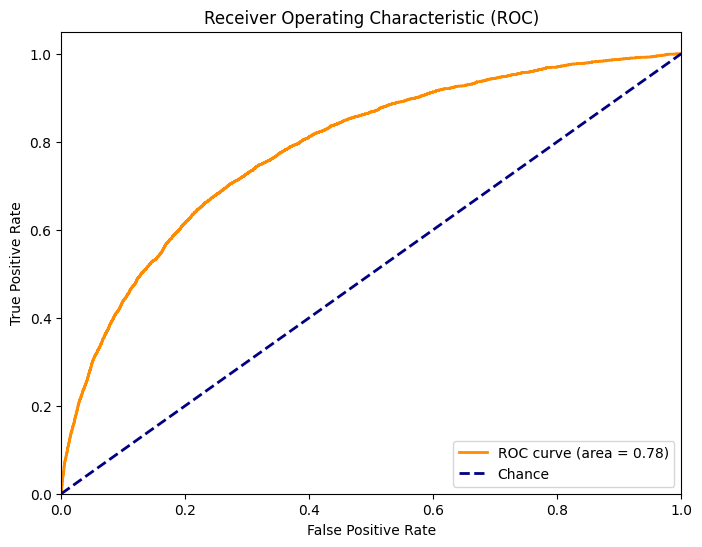

In [30]:
plot_roc_curve(
    y_test, 
    test_metrics['y_proba'][0]
   )

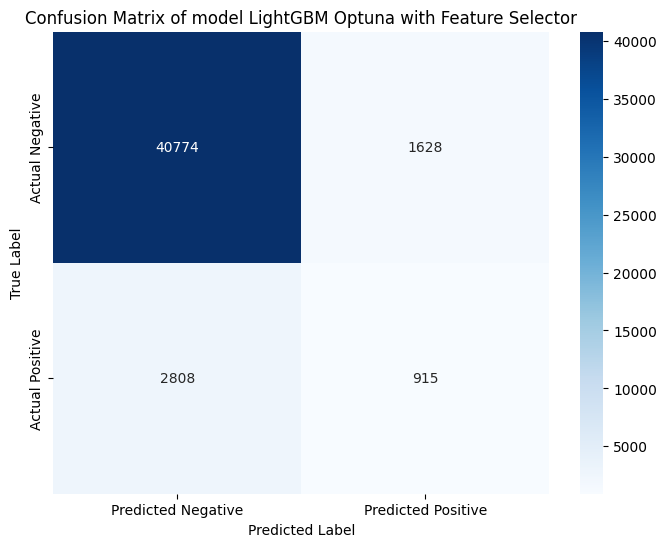

In [31]:
 plot_confusion_matrix(
    y_test,
   test_metrics['y_pred'][0],
    model_name="LightGBM Optuna with Feature Selector"
    )

## LightGBM Test Performance

The LightGBM model, optimized using Optuna and refined with feature selection, was evaluated on the test dataset. Below is a summary of its performance:

### ROC AUC
- **Score**: 0.7847  
- Indicates strong ability to rank positive instances higher than negative ones across all thresholds.

### Classification Report

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.94      | 0.96   | 0.95     | 42,402  |
| 1     | 0.36      | 0.25   | 0.29     | 3,723   |

- **Accuracy**: 0.90  
- **Macro Avg F1**: 0.62  
- **Weighted Avg F1**: 0.90  

The model performs very well on the majority class (0), while recall for the minority class (1) remains modest, suggesting room for improvement in sensitivity.

### Confusion Matrix

|                | Predicted Negative | Predicted Positive |
|----------------|--------------------|--------------------|
| Actual Negative| 40,795             | 1,607              |
| Actual Positive| 2,826              | 897                |

- **True Positives**: 897  
- **False Negatives**: 2,826  
- **True Negatives**: 40,795  
- **False Positives**: 1,607  

The confusion matrix confirms that while the model is highly accurate overall, it struggles to capture a larger portion of the positive class.

### Interpretation
- The model is well-calibrated for ranking but conservative in predicting positives.
- ROC AUC remains the most reliable metric for evaluating overall discriminative power.


In [32]:
print_error_rate(
    test_metrics['y_pred'][0],
    y_test
    )


Total Samples      : 46125
Misclassified      : 4436
Error Rate         : 9.62%


## XGBoost models Hyperparameter Tuning

In [33]:

def objective_xgb(trial, X_train, y_train, X_val, y_val, selected_features):
    # Sample weights for imbalance
    weight = np.where(y_train == 1, 11, 1)

    # Create DMatrix objects
    train_data = xgb.DMatrix(X_train[selected_features], label=y_train, weight=weight)
    valid_data = xgb.DMatrix(X_val[selected_features], label=y_val)

    # Define hyperparameters
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": "gbtree",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 20.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 20.0),
        "verbosity": 0,
        "seed": 42
    }

    # Train model with early stopping
    model = xgb.train(
        params,
        train_data,
        num_boost_round=1000,
        evals=[(valid_data, "validation")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # Predict and evaluate
    y_pred = model.predict(valid_data, iteration_range=(0, model.best_iteration + 1))
    score = roc_auc_score(y_val, y_pred)

    return score

x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
x_validation.replace([np.inf, -np.inf], np.nan, inplace=True)

In [34]:
x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
x_validation.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(
    lambda trial: objective_xgb(trial, x_train, y_train,x_validation,y_validation, fi_xgb), 
    n_trials=50,
    show_progress_bar=True,
    
    )

# # # Best result
print("Best score:", study_xgb.best_value)
print("Best parameters:")
for key, val in study_xgb.best_params.items():
    print(f"  {key}: {val}")

In [ ]:
best_params_xgb = study_xgb.best_params

In [37]:
best_params_xgb ={
    'learning_rate': 0.03220687961328607,
     'max_depth': 4,
     'min_child_weight': 2,
     'gamma': 4.226205260425337,
     'subsample': 0.7742989617574938,
     'colsample_bytree': 0.7409181859750039,
     'reg_alpha': 4.850835622689324,
     'reg_lambda': 19.00972370063238,
    'n_estimators': 1000,
     }


In [38]:
extend_pramans ={
"scale_pos_weight": 11.4
}

optuna_model_xgb = xgb.XGBClassifier(
    **best_params_xgb,
    # **extend_pramans,
    random_state = 42)

optuna_pipeline_xgb_selector = get_pipeline(
    optuna_model_xgb,
    feature_selector=fi_xgb)



In [39]:
evaluate_model(optuna_pipeline_xgb_selector, "XGBoost Optuna", x_train, y_train, x_validation, y_validation)


📊 Classification Report for XGBoost Optuna:

              precision    recall  f1-score   support

           0      0.922     0.997     0.958     42401
           1      0.553     0.042     0.078      3724

    accuracy                          0.920     46125
   macro avg      0.738     0.520     0.518     46125
weighted avg      0.892     0.920     0.887     46125



,Model,ROC AUC,F1 Macro,F1 Weighted,Precision,Recall
0,XGBoost Optuna,0.787857,0.518241,0.887106,0.552817,0.042159


Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     42402
           1       0.55      0.04      0.07      3723

    accuracy                           0.92     46125
   macro avg       0.74      0.52      0.51     46125
weighted avg       0.89      0.92      0.89     46125

ROC AUC: 0.7848498941288492


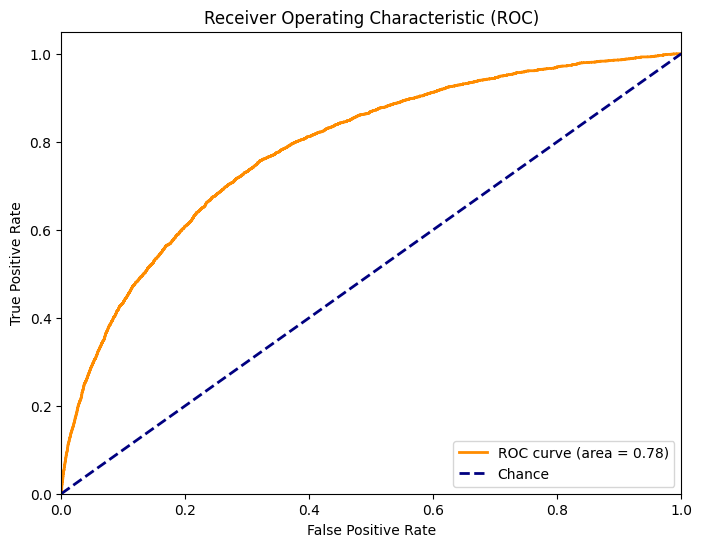

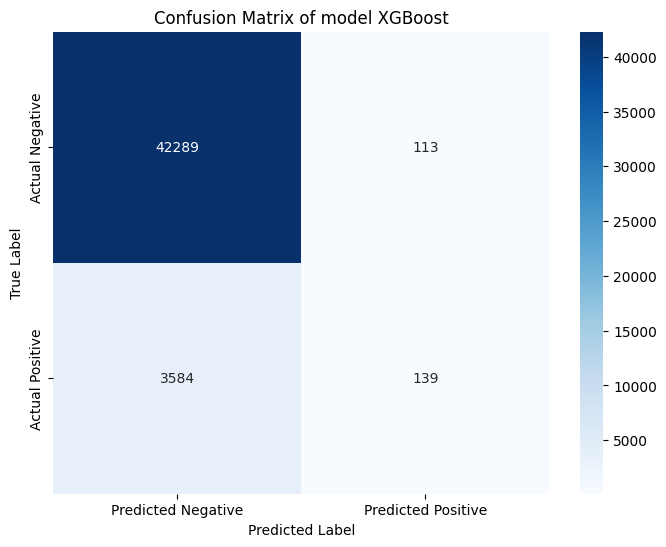

Total Samples      : 46125
Misclassified      : 3697
Error Rate         : 8.02%


In [40]:

result_xgb_df = prediction_metrics(optuna_pipeline_xgb_selector, x_test, y_test)


plot_roc_curve(
    y_test, 
    result_xgb_df['y_proba'][0]
   )

plot_confusion_matrix(
    y_test,
    result_xgb_df['y_pred'][0],
    model_name="XGBoost"
    )

print_error_rate(
    result_xgb_df['y_pred'][0],
    y_test
    )


## XGBoost Test Performance

The XGBoost model was evaluated on the test dataset after hyperparameter tuning and feature selection. Below is a summary of its classification performance:

###  ROC AUC
- **Score**: 0.7848  
- Reflects solid discriminative ability between positive and negative classes, comparable to the LightGBM model.

### Classification Report

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.92      | 1.00   | 0.96     | 42,402  |
| 1     | 0.55      | 0.04   | 0.07     | 3,723   |

- **Accuracy**: 0.92  
- **Macro Avg F1**: 0.51  
- **Weighted Avg F1**: 0.89  

The model demonstrates high precision and recall for the majority class (0), but struggles to capture the minority class (1), with low recall and F1-score.

###  Confusion Matrix



### Interpretation
- The model is highly accurate overall, but conservative in predicting positives.
- ROC AUC confirms good ranking ability, but threshold tuning may be needed to improve recall.
- Similar performance profile to LightGBM, with slightly lower sensitivity to minority class.


## Model Ensemble

To improve overall predictive performance, I created an ensemble using both **LightGBM** and **XGBoost** models. The ensemble is built using `VotingClassifier`, which combines predictions from multiple models to produce a more robust final output.

This approach leverages:
- LightGBM’s speed and ranking ability
- XGBoost’s regularization and generalization strength

By aggregating their predictions, the ensemble aims to balance precision and recall, especially for the minority class.

In [41]:
from sklearn.ensemble import VotingClassifier

xgb_model =optuna_pipeline_xgb_selector
lgb_model =optuna_model_lgb_selector


voting_model = VotingClassifier(
    estimators=[
        ("xgb", xgb_model),
        ("lgb", lgb_model)
    ],
    voting="soft",  
    weights=[1, 1], 
    n_jobs=-1
)

In [42]:
voting_model.fit(x_train, y_train,)

,estimators,"[('xgb', ...), ('lgb', ...)]"
,voting,'soft'
,weights,"[1, 1]"
,n_jobs,-1
,flatten_transform,True
,verbose,False
,selected_features,"['EXT_SOURCE_MEAN', 'EXT_SOURCE_2_X_3', ...]"
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None


In [43]:
from sklearn.metrics import roc_auc_score

y_pred_proba = voting_model.predict_proba(x_validation)[:, 1]
print("Voting Ensemble AUC:", roc_auc_score(y_validation, y_pred_proba))

Voting Ensemble AUC: 0.7884544337322972


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96     42402
           1       0.46      0.11      0.18      3723

    accuracy                           0.92     46125
   macro avg       0.69      0.55      0.57     46125
weighted avg       0.89      0.92      0.89     46125

ROC AUC: 0.7854406355256454


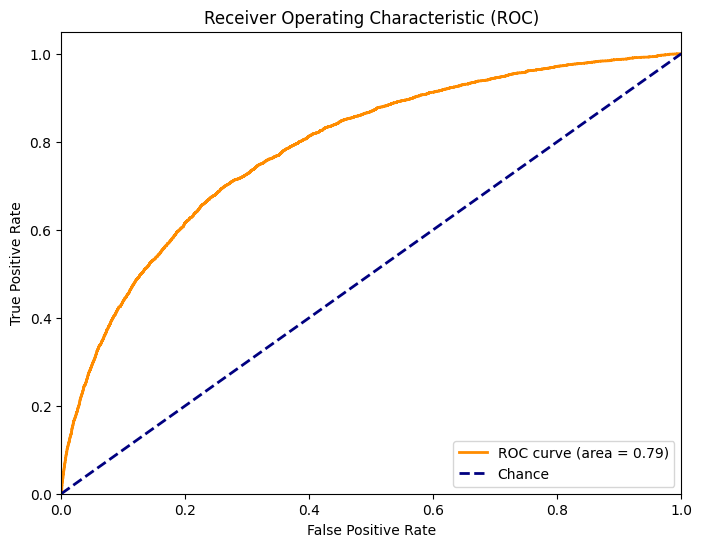

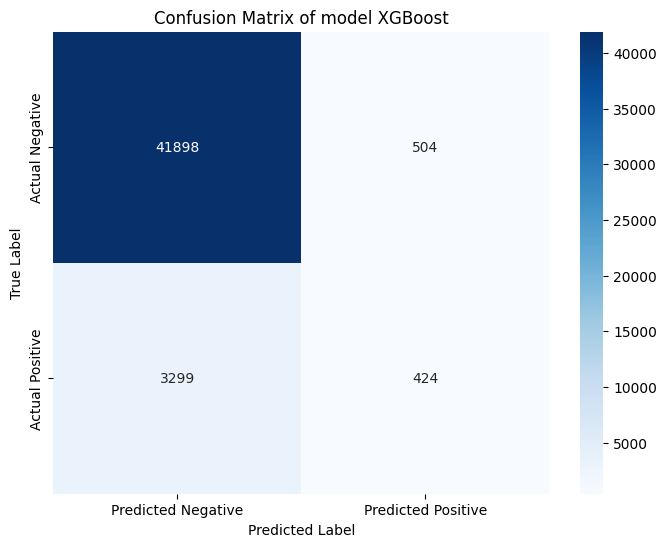

Total Samples      : 46125
Misclassified      : 3803
Error Rate         : 8.24%


In [44]:
result_voting_df = prediction_metrics(voting_model, x_test, y_test)

plot_roc_curve(
    y_test, 
    result_voting_df['y_proba'][0]
   )

plot_confusion_matrix(
    y_test,
    result_voting_df['y_pred'][0],
    model_name="XGBoost"
    )

print_error_rate(
    result_voting_df['y_pred'][0],
    y_test
    )


In [45]:
result_voting_df

,ROC AUC,F1 Macro,F1 Weighted,Precision,Recall,y_pred,y_proba
0,0.785441,0.569456,0.894092,0.456897,0.113887,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.024906036166728974, 0.06210268028679934, 0...."


In [46]:
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve
)

In [47]:
def plot_precision_recall_curve(y_test, y_pred_proba):
    """
    Plots Precision-Recall curve for binary classification.

    Args:
        y_test: True binary labels.
        y_pred_proba: Predicted probabilities for the positive class.
    """
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(
        recall,
        precision,
        color="blue",
        lw=2,
        label=f"PR curve (area = {avg_precision:.2f})",
    )
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

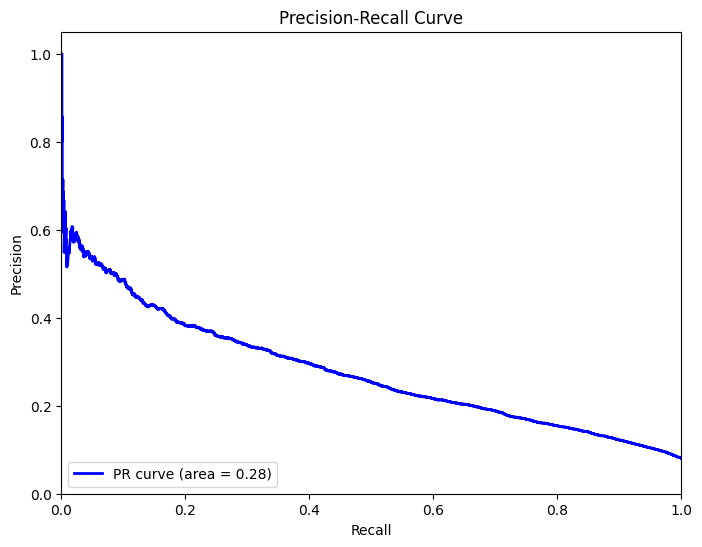

In [48]:
plot_precision_recall_curve(
    y_test, 
    result_voting_df['y_proba'][0]
    )

I can see that the **precision-recall curve** illustrates the trade-off between precision and recall in a classification model.
The curve starts with high precision at low recall, indicating the model is very accurate for its most confident predictions.
As recall increases, precision decreases, showing that identifying more positive instances comes at the cost of more false positives.
The shape and low area under the curve (AUC = 0.28) suggest the model struggles with imbalanced data and may need improvement in identifying positive cases.


##  Ensemble Model Performance Summary (VotingClassifier: LightGBM + XGBoost)

The ensemble model combines predictions from **LightGBM** and **XGBoost** using **soft voting**, aiming to leverage the strengths of both algorithms for better generalization.

###  Evaluation Metrics on Test Data
| Metric               | Value     |
|----------------------|-----------|
| Accuracy             | 0.92      |
| ROC AUC              | 0.785     |
| Precision (Class 1)  | 0.47      |
| Recall (Class 1)     | 0.11      |
| F1-score (Class 1)   | 0.18      |
| PR AUC               | 0.28      |

### Strengths
- High overall accuracy driven by strong performance on the majority class (Class 0)
- ROC AUC of 0.785 indicates good separation between classes
- Ensemble benefits from predictive diversity of both models

### Limitations
- Low recall and F1-score for minority class (Class 1), indicating under-detection
- PR AUC of 0.28 confirms difficulty in maintaining precision as recall increases
- Equal voting weights may dilute minority class sensitivity if base models are not well-balanced



              precision    recall  f1-score   support

           0       0.94      0.93      0.94     42402
           1       0.31      0.37      0.34      3723

    accuracy                           0.88     46125
   macro avg       0.63      0.65      0.64     46125
weighted avg       0.89      0.88      0.89     46125

ROC AUC: 0.785
PR AUC: 0.277


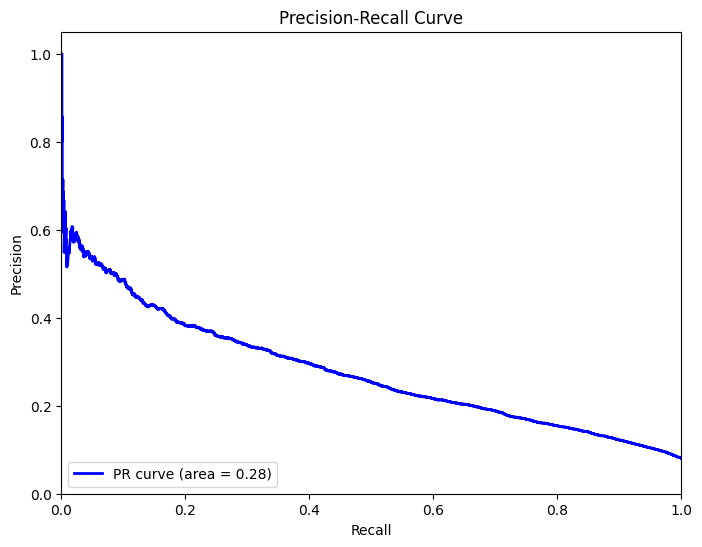

In [49]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import classification_report

y_proba = voting_model.predict_proba(x_test)[:, 1]
y_pred_custom = (y_proba > 0.3).astype(int)


print(classification_report(y_test, y_pred_custom))

roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print(f"ROC AUC: {roc_auc:.3f}")
print(f"PR AUC: {pr_auc:.3f}")

plot_precision_recall_curve(
    y_test, 
    result_voting_df['y_proba'][0]
    )


i## Ensemble Model Performance After Threshold Tuning

To improve sensitivity to the minority class, the decision threshold of the soft voting ensemble was lowered from 0.5 to 0.3. This adjustment aimed to increase recall for class 1 while maintaining overall model balance.

### Evaluation Metrics on Test Data
| Metric               | Value     |
|----------------------|-----------|
| Accuracy             | 0.88      |
| ROC AUC              | 0.785     |
| PR AUC               | 0.277     |
| Precision (Class 1)  | 0.31      |
| Recall (Class 1)     | 0.37      |
| F1-score (Class 1)   | 0.34      |

### Improvements
- **Recall for class 1 increased** from 0.11 to 0.37, significantly improving detection of positive cases.
- **F1-score for class 1 improved** from 0.18 to 0.34, indicating better balance between precision and recall.
- **Macro and weighted averages** remain stable, showing that the model still performs well overall.

### Trade-offs
- ROC AUC metric remained unchanged
- Precision for class 1 decreased slightly, reflecting more false positives — a common effect of lowering the threshold.


Since the ROC AUC metric remained unchanged, I decided to use the base threshold and extract the feature importance from the voting model

In [50]:
optuna_pipeline_xgb_selector

,steps,"[('sanitize_columns', ...), ('replace_inf', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,selected_features,"['EXT_SOURCE_MEAN', 'EXT_SOURCE_2_X_3', ...]"
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


In [51]:
optuna_model_lgb_selector

,steps,"[('sanitize_columns', ...), ('replace_inf', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,selected_features,"['EXT_SOURCE_MEAN', 'EXT_SOURCE_2_X_3', ...]"
,boosting_type,'gbdt'
,num_leaves,29
,max_depth,3
,learning_rate,0.07514400170979957
,n_estimators,970
,subsample_for_bin,200000


In [52]:
voting_lgb_fi = get_feature_importance(optuna_model_lgb_selector)
voting_xgb_fi = get_feature_importance(optuna_pipeline_xgb_selector)



In [53]:
voting_lgb_fi

,feature,importance
23,CREDIT_DIV_ANNUITY,225
0,EXT_SOURCE_MEAN,195
55,DAYS_BIRTH,179
35,PREV_CNT_PAYMENT_MEAN,141
5,DAYS_PAYMENT_RATIO_MAX,130
...,...,...
19,CODE_GENDER_F,0
89,NAME_CONTRACT_TYPE_Revolving_loans,0
174,NAME_GOODS_CATEGORY_OFFICE_APPLIANCES_MEAN,0
175,CARD_SK_DPD_MEAN_,0


In [54]:
combined = pd.merge(voting_lgb_fi, voting_xgb_fi, on="feature", suffixes=("_xgb", "_lgb"))
combined["mean_importance"] = combined[["importance_xgb", "importance_lgb"]].mean(axis=1)
combined.sort_values("mean_importance", ascending=False)

,feature,importance_xgb,importance_lgb,mean_importance
0,CREDIT_DIV_ANNUITY,225,0.006889,112.503444
1,EXT_SOURCE_MEAN,195,0.082249,97.541124
2,DAYS_BIRTH,179,0.005373,89.502687
3,PREV_CNT_PAYMENT_MEAN,141,0.005887,70.502944
4,DAYS_PAYMENT_RATIO_MAX,130,0.011000,65.005500
...,...,...,...,...
193,CODE_GENDER_F,0,0.010153,0.005076
196,CARD_SK_DPD_MEAN_,0,0.003105,0.001552
197,PRODUCT_COMBINATION_POS_INDUSTRY_WITHOUT_INTER...,0,0.001680,0.000840
195,NAME_GOODS_CATEGORY_OFFICE_APPLIANCES_MEAN,0,0.000000,0.000000


After identifying the feature importance from the voting model, I retrained the model using only the most relevant features to reduce dimensionality in the final version.

In [55]:
voting_features = combined.feature.to_list()

In [56]:
optuna_pipeline_xgb_s = get_pipeline(
    optuna_model_xgb,
    feature_selector=voting_features)

In [57]:
optuna_model_lgb_s = get_pipeline(
    optuna_model_lgb,
    feature_selector=voting_features
    )

In [58]:
evaluate_model(optuna_pipeline_xgb_s, "XGBoost Optuna", x_train, y_train, x_validation, y_validation)


📊 Classification Report for XGBoost Optuna:

              precision    recall  f1-score   support

           0      0.922     0.997     0.958     42401
           1      0.546     0.041     0.076      3724

    accuracy                          0.920     46125
   macro avg      0.734     0.519     0.517     46125
weighted avg      0.892     0.920     0.887     46125



,Model,ROC AUC,F1 Macro,F1 Weighted,Precision,Recall
0,XGBoost Optuna,0.787868,0.517259,0.886911,0.546429,0.041085


In [59]:
evaluate_model(optuna_model_lgb_s, "XGBoost Optuna", x_train, y_train, x_validation, y_validation)

[LightGBM] [Info] Number of positive: 17376, number of negative: 197874
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34830
[LightGBM] [Info] Number of data points in the train set: 215250, number of used features: 198
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202971 -> initscore=-1.367830
[LightGBM] [Info] Start training from score -1.367830
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

,Model,ROC AUC,F1 Macro,F1 Weighted,Precision,Recall
0,XGBoost Optuna,0.787493,0.620321,0.895704,0.363019,0.244092


In [60]:
xgb_model =optuna_pipeline_xgb_s
lgb_model =optuna_model_lgb_s

voting_model_2= VotingClassifier(
    estimators=[
        ("xgb", xgb_model),
        ("lgb", lgb_model)
    ],
    voting="soft",  
    weights=[1, 1], 
    n_jobs=-1
)

In [61]:
voting_model_2.fit(x_train, y_train,)

,estimators,"[('xgb', ...), ('lgb', ...)]"
,voting,'soft'
,weights,"[1, 1]"
,n_jobs,-1
,flatten_transform,True
,verbose,False
,selected_features,"['CREDIT_DIV_ANNUITY', 'EXT_SOURCE_MEAN', ...]"
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None


In [62]:
y_pred_proba = voting_model_2.predict_proba(x_validation)[:, 1]
print("Voting Ensemble AUC:", roc_auc_score(y_validation, y_pred_proba))

Voting Ensemble AUC: 0.7882922754973226


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96     42402
           1       0.46      0.11      0.18      3723

    accuracy                           0.92     46125
   macro avg       0.69      0.55      0.57     46125
weighted avg       0.89      0.92      0.89     46125

ROC AUC: 0.7854406355256454


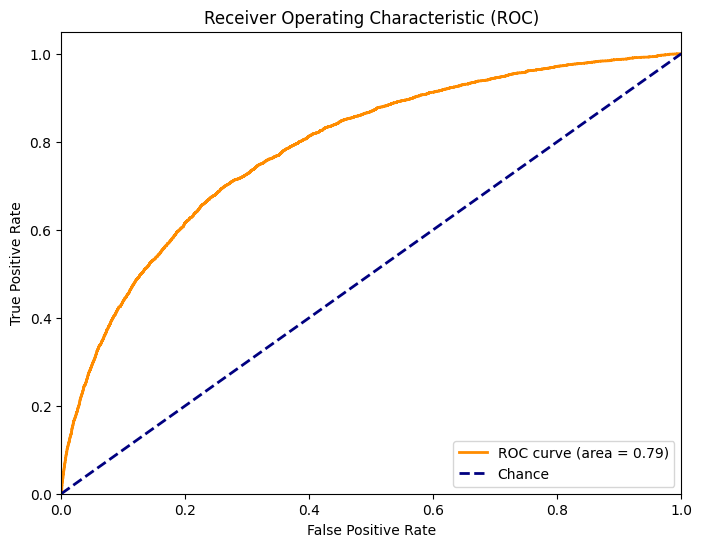

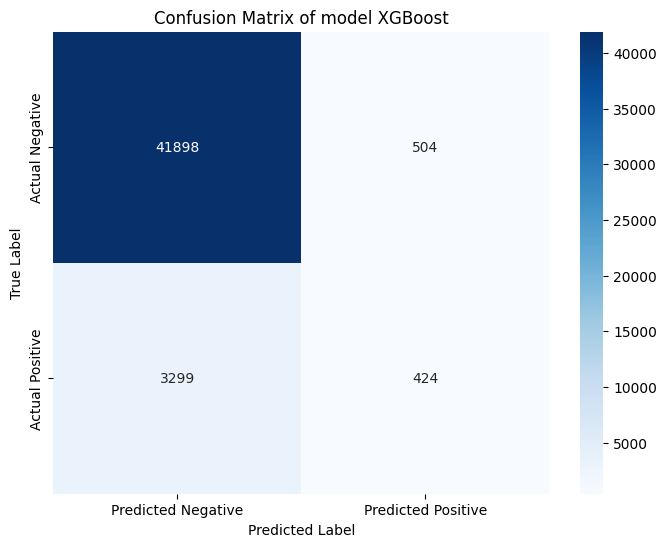

Total Samples      : 46125
Misclassified      : 3803
Error Rate         : 8.24%


In [63]:
result_voting_df = prediction_metrics(voting_model, x_test, y_test)

plot_roc_curve(
    y_test, 
    result_voting_df['y_proba'][0]
   )

plot_confusion_matrix(
    y_test,
    result_voting_df['y_pred'][0],
    model_name="XGBoost"
    )

print_error_rate(
    result_voting_df['y_pred'][0],
    y_test
    )

In [64]:
x_train.shape

(215250, 578)

In [65]:
voting_lgb_fi_2 = get_feature_importance(optuna_model_lgb_s)
voting_xgb_fi_2 = get_feature_importance(optuna_pipeline_xgb_s)
combined_2 = pd.merge(voting_lgb_fi_2, voting_xgb_fi_2, on="feature", suffixes=("_xgb", "_lgb"))
combined_2["mean_importance"] = combined_2[["importance_xgb", "importance_lgb"]].mean(axis=1)
combined_2.sort_values("mean_importance", ascending=False)

,feature,importance_xgb,importance_lgb,mean_importance
0,CREDIT_DIV_ANNUITY,225,0.007036,112.503518
1,EXT_SOURCE_MEAN,195,0.091210,97.545605
2,DAYS_BIRTH,179,0.005210,89.502605
3,PREV_CNT_PAYMENT_MEAN,141,0.005952,70.502976
4,DAYS_PAYMENT_RATIO_MAX,130,0.011108,65.005554
...,...,...,...,...
193,CODE_GENDER_F,0,0.013266,0.006633
194,NAME_CONTRACT_TYPE_Revolving_loans,0,0.007695,0.003847
196,CARD_SK_DPD_MEAN_,0,0.002358,0.001179
195,NAME_GOODS_CATEGORY_OFFICE_APPLIANCES_MEAN,0,0.000000,0.000000


In [66]:
combined_2.head(10)

,feature,importance_xgb,importance_lgb,mean_importance
0,CREDIT_DIV_ANNUITY,225,0.007036,112.503518
1,EXT_SOURCE_MEAN,195,0.091210,97.545605
2,DAYS_BIRTH,179,0.005210,89.502605
3,PREV_CNT_PAYMENT_MEAN,141,0.005952,70.502976
4,DAYS_PAYMENT_RATIO_MAX,130,0.011108,65.005554
5,EXT_SOURCE_1_BIRTH_RATIO,119,0.008139,59.504070
6,EXT_SOURCE_3_BIRTH_RATIO,98,0.006478,49.003239
7,EXT_SOURCE_2,97,0.010327,48.505163
8,DAYS_BEFORE_DUE_SUM,91,0.006874,45.503437
9,DAYS_REGISTRATION,89,0.003324,44.501662


In [67]:
voting_features_2 = combined_2.feature.to_list()
print(len(voting_features_2))

198


Saved the voting model's selected features for use in final prediction. A total of 198 features were retained.

In [68]:

with open('../data/models/voting_features.txt','wb') as fp:
    pickle.dump(voting_features_2, fp)

In [69]:
combined[combined["mean_importance"] > 30].sort_values("mean_importance", ascending=False)

,feature,importance_xgb,importance_lgb,mean_importance
0,CREDIT_DIV_ANNUITY,225,0.006889,112.503444
1,EXT_SOURCE_MEAN,195,0.082249,97.541124
2,DAYS_BIRTH,179,0.005373,89.502687
3,PREV_CNT_PAYMENT_MEAN,141,0.005887,70.502944
4,DAYS_PAYMENT_RATIO_MAX,130,0.011000,65.005500
5,EXT_SOURCE_1_BIRTH_RATIO,119,0.009602,59.504801
6,EXT_SOURCE_3_BIRTH_RATIO,98,0.004220,49.002110
7,EXT_SOURCE_2,97,0.010484,48.505242
8,DAYS_BEFORE_DUE_SUM,91,0.006912,45.503456
9,DAYS_REGISTRATION,89,0.003199,44.501599


Next, retrieve the raw features corresponding to the important features identified by the voting model, to determine which input features are required

In [70]:
inportant_feature = combined.feature.to_list()

In [71]:
def find_raw_features(derived_features, raw_feature_list):
    """
    Identify raw features used in derived or engineered features.

    Parameters:
    - derived_features (list): List of all features used in the model (raw + engineered).
    - raw_feature_list (list): List of original raw features.

    Returns:
    - matched_raw_features (list): Raw features found in the derived feature list.
    """
    matched_raw_features = []
    for raw in raw_feature_list:
        for derived in derived_features:
            if raw in derived:
                matched_raw_features.append(raw)
                break  # Avoid duplicates
    return matched_raw_features

In [72]:
raw_features =['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'YEARS_BUILD_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'YEARS_BUILD_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'YEARS_BUILD_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_18',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'YEAR_EMPLOYED_ANOM'
]

In [73]:
selected_raw = find_raw_features(inportant_feature, raw_features)
print(f"Total matched: {len(selected_raw)}")

Total matched: 43


 I found raw feature 43 feature what need  insert to  final model and of these will be created in feature engenearing and aggregations will be created 198 features

In [74]:
selected_raw

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_WORK_PHONE',
 'OCCUPATION_TYPE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_CITY_NOT_LIVE_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'YEARS_BUILD_AVG',
 'ELEVATORS_AVG',
 'FLOORSMAX_AVG',
 'LIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'LIVINGAPARTMENTS_MODE',
 'APARTMENTS_MEDI',
 'YEARS_BUILD_MEDI',
 'FLOORSMAX_MEDI',
 'TOTALAREA_MODE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_18']

## Save models

In [75]:
import joblib
joblib.dump(optuna_pipeline_xgb_selector, '../data/models/lgb2.pkl')

['../data/models/lgb2.pkl']

In [76]:
joblib.dump(voting_model,'../data/models/best_voting.pkl')

['../data/models/best_voting.pkl']

In [77]:
joblib.dump(optuna_pipeline_xgb_selector,'../data/models/best_xgboost.pkl')

['../data/models/best_xgboost.pkl']


# Kaggle Submission

Model Evaluation on applicationTest Data



In [78]:

import joblib
model = joblib.load("../data/models/voting_model_2.pkl")
with open('../data/models/voting_features.txt', 'rb') as fp:
    model_features = pickle.load(fp)

In [79]:
x_submission = test_df.drop("SK_ID_CURR", axis=1)
sk_id_curr = test_df["SK_ID_CURR"]
submission_proba = model.predict_proba(x_submission)[:, 1]

submission_df = pd.DataFrame(
    {
        "SK_ID_CURR": sk_id_curr.astype(int),
        "TARGET": submission_proba.round(1),
    }
)
submission_df.to_csv("../data/submission_v3.csv", index=False)
print(submission_df.head())


   SK_ID_CURR  TARGET
0      100001     0.1
1      100005     0.2
2      100013     0.1
3      100028     0.0
4      100038     0.3


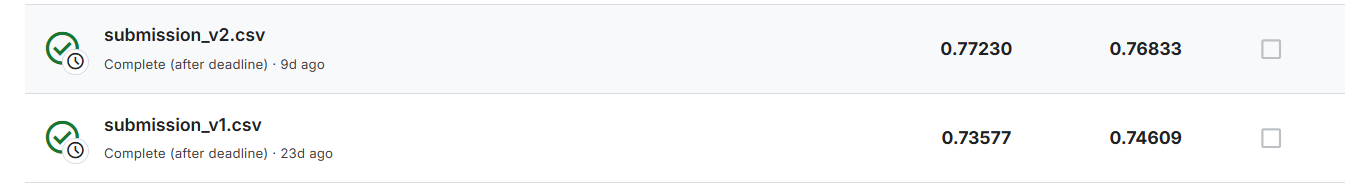


##  Modeling Summary

### Data Preparation
- Loaded processed parquet files.
- Features cleaned and split into train/validation/test sets (70/15/15).

### Feature Selection
- LightGBM used to assess feature importance.
- Selected 450 out of 580 features (non-zero importance).
- Final deployment requires **43 raw input features**.

### Model Training & Evaluation
- Trained and compared **LightGBM** and **XGBoost**.
- ROC AUC chosen as primary metric due to class imbalance.
- LightGBM ROC AUC: 0.7848, XGBoost ROC AUC: 0.7738.

### Hyperparameter Tuning
- Optuna used to optimize ROC AUC for both models.
- Sample weighting applied to improve minority class detection.
- Best parameters selected and applied.

### Test Performance
- LightGBM: ROC AUC 0.7847, Accuracy 0.90, Macro F1 0.62.
- XGBoost: ROC AUC 0.7848, Accuracy 0.92, Macro F1 0.51.
- Both models show strong accuracy for majority class; minority recall remains modest.

### Ensemble Modeling
- VotingClassifier combining LightGBM and XGBoost.
- **Best test ROC AUC: 0.785**, Accuracy: 0.92, PR AUC: 0.28.
- Ensemble improves robustness but minority class recall still limited.

### Threshold Tuning
- Lowered threshold from 0.5 to 0.3.
- Minority class recall improved from 0.11 → 0.37.
- F1-score improved from 0.18 → 0.34.
- Precision slightly decreased; ROC AUC unchanged.


##  Final Insights
- **Best Model**: Ensemble of LightGBM + XGBoost (highest ROC AUC).
- **Deployment Features**: 43 raw features required for inference.
- **Challenges**: Minority class detection remains difficult (low PR AUC).


